In [ ]:
import os
import pandas as pd

def collect_all_data(folder_path, value_column_name):
   
    all_data = []

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)

                try:
                   
                    date_part = file.split('_')[0]

                  
                    df = pd.read_csv(file_path)

                   
                    value_col = next((col for col in df.columns if col.lower() not in ['date', 'timestamp']), None)

                    if value_col:
                        df = df[[value_col]].copy()
                        df.columns = [value_column_name]  
                        df.insert(0, 'Date', date_part)
                        all_data.append(df)

                except Exception as e:
                    print(f"⚠️ Skipped {file_path} due to error: {e}")

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame(columns=['Date', value_column_name])


ghi_df = collect_all_data('GHI', 'GHI')
pr_df = collect_all_data('PR', 'PR')


if not ghi_df.empty and not pr_df.empty:
    
    ghi_df['row'] = ghi_df.groupby('Date').cumcount()
    pr_df['row'] = pr_df.groupby('Date').cumcount()

    merged_df = pd.merge(ghi_df, pr_df, on=['Date', 'row'], how='inner').drop(columns='row')

    print("✅ Final shape:", merged_df.shape) 
    merged_df.to_csv('final_merged_all_rows.csv', index=False)
    print("📁 File saved as final_merged_all_rows.csv")
else:
    print("❌ One of the data folders is empty or has bad files.")


✅ Final shape: (982, 3)
📁 File saved as final_merged_all_rows.csv


In [17]:
df=pd.read_csv('final_merged_all_rows.csv')

In [18]:
df.head()

,Date,GHI,PR
0,2019-07-01.csv,3.256608,69.575676
1,2019-07-01.csv,3.976767,79.314411
2,2019-07-01.csv,2.811867,61.020006
3,2019-07-01.csv,3.658408,83.262576
4,2019-07-01.csv,5.590683,82.124440


In [19]:
df.shape

(982, 3)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    982 non-null    object 
 1   GHI     982 non-null    float64
 2   PR      982 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.1+ KB


Final shape: (982, 3)
        Date       GHI         PR
0 2019-07-01  3.256608  69.575676
1 2019-07-01  3.976767  79.314411
2 2019-07-01  2.811867  61.020006
3 2019-07-01  3.658408  83.262576
4 2019-07-01  5.590683  82.124440


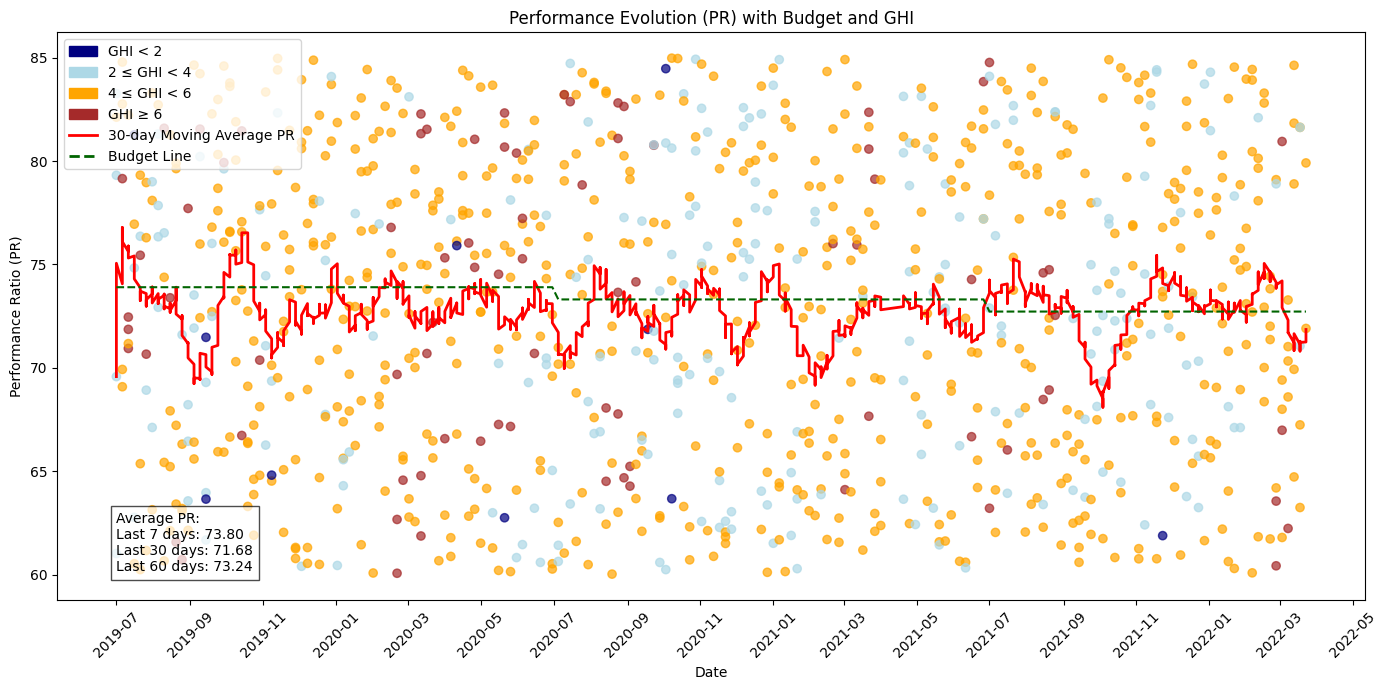

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def load_and_preprocess(csv_path):
    
    df = pd.read_csv(csv_path)
    df['Date'] = df['Date'].str.replace('.csv', '', regex=False)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date']).reset_index(drop=True)
    return df

def plot_performance_evolution(df, start_date=None, end_date=None):
   
    df = df.sort_values('Date').reset_index(drop=True)
    
    
    if start_date:
        start_dt = pd.to_datetime(start_date)
        df = df[df['Date'] >= start_dt]
    if end_date:
        end_dt = pd.to_datetime(end_date)
        df = df[df['Date'] <= end_dt]
    
    if df.empty:
        print("No data available for the given date range.")
        return

    df['PR_MA30'] = df['PR'].rolling(window=30, min_periods=1).mean()

    budget_start_value = 73.9
    annual_decay_rate = 0.008  # 0.8%
    start_date_for_budget = pd.Timestamp('2019-07-01')

    def budget_value(date):
        year_num = ((date.year - 2019) * 12 + date.month - 7) // 12
        return budget_start_value * ((1 - annual_decay_rate) ** year_num)

    df['Budget_PR'] = df['Date'].apply(budget_value)

    def ghi_color(ghi):
        if ghi < 2:
            return 'navy'
        elif 2 <= ghi < 4:
            return 'lightblue'
        elif 4 <= ghi < 6:
            return 'orange'
        else:
            return 'brown'

    df['Color'] = df['GHI'].apply(ghi_color)

    plt.figure(figsize=(14, 7))

    plt.scatter(df['Date'], df['PR'], c=df['Color'], alpha=0.7, label='Daily PR')
    plt.plot(df['Date'], df['PR_MA30'], color='red', label='30-day Moving Average PR', linewidth=2)
    plt.plot(df['Date'], df['Budget_PR'], color='darkgreen', linestyle='--', label='Budget Line')

    import matplotlib.patches as mpatches
    legend_handles = [
        mpatches.Patch(color='navy', label='GHI < 2'),
        mpatches.Patch(color='lightblue', label='2 ≤ GHI < 4'),
        mpatches.Patch(color='orange', label='4 ≤ GHI < 6'),
        mpatches.Patch(color='brown', label='GHI ≥ 6'),
        plt.Line2D([0], [0], color='red', lw=2, label='30-day Moving Average PR'),
        plt.Line2D([0], [0], color='darkgreen', lw=2, linestyle='--', label='Budget Line'),
    ]
    plt.legend(handles=legend_handles, loc='upper left')

    plt.title('Performance Evolution (PR) with Budget and GHI')
    plt.xlabel('Date')
    plt.ylabel('Performance Ratio (PR)')

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    last_date = df['Date'].max()
    avg_7 = df.loc[df['Date'] > last_date - pd.Timedelta(days=7), 'PR'].mean()
    avg_30 = df.loc[df['Date'] > last_date - pd.Timedelta(days=30), 'PR'].mean()
    avg_60 = df.loc[df['Date'] > last_date - pd.Timedelta(days=60), 'PR'].mean()

    avg_text = (f'Average PR:\n'
                f'Last 7 days: {avg_7:.2f}\n'
                f'Last 30 days: {avg_30:.2f}\n'
                f'Last 60 days: {avg_60:.2f}')

    plt.text(df['Date'].min(), df['PR'].min(), avg_text,
             verticalalignment='bottom', horizontalalignment='left',
             bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()




if __name__ == "__main__":
    merged_csv_path = 'final_merged_all_rows.csv'
    df = load_and_preprocess(merged_csv_path)

    print("Final shape:", df.shape)
    print(df.head())

   
    plot_performance_evolution(df)

  